# Iowa Liquor Sale Data Preparation

## Setup and imports


In [27]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("ggplot")
mpl.rcParams['figure.figsize'] = (13,8)
import seaborn as sns


# Metrics and useful imports
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Understand

### Iowa Liquor Sales (sales & distributions) (Jan 1, 2012 - Feb 29, 2020)
This dataset contains the spirits purchase information of Iowa Class “E” liquor licensees by product and date of purchase from January 1, 2012 to current. The dataset can be used to analyze total spirits sales in Iowa of individual products at the store level.

### Data Set Characteristics:

Number of Instances: 18,098,417 (as of 29 Feb 2020)

Number of Attributes: 24 attributes

### Attribute Information: 

**1.Invoice/Item Number:** Concatenated invoice and line number associated with the liquor order. This provides a unique identifier for the individual liquor products included in the store order

**2.Date:** Date of order

**3.Store Number:** Unique number assigned to the store who ordered the liquor.

**4.Store Name:** Name of store who ordered the liquor.

**5.Address:** Address of store who ordered the liquor.

**6.City:** City where the store who ordered the liquor is located

**7.Zip Code:** Zip code where the store who ordered the liquor is located

**8.Store Location:** Location of store who ordered the liquor. The Address, City, State and Zip Code are geocoded to provide geographic coordinates. Accuracy of geocoding is dependent on how well the address is interpreted and the completeness of the reference data used.

**9.County Number:** Iowa county number for the county where store who ordered the liquor is located

**10.County:** County where the store who ordered the liquor is located

**11.Category:** Category code associated with the liquor ordered

**12.Category Name:** Category of the liquor ordered.

**13.Vendor Number:** The vendor number of the company for the brand of liquor ordered

**14.Vendor Name:** The vendor name of the company for the brand of liquor ordered

**15.Item Number:** Item number for the individual liquor product ordered.

**16.Item Description:** Description of the individual liquor product ordered.

**17.Pack:** The number of bottles in a case for the liquor ordered

**18.Bottle Volume (ml):** Volume of each liquor bottle ordered in milliliters.

**19.State Bottle Cost:** The amount that Alcoholic Beverages Division paid for each bottle of liquor ordered

**20.State Bottle Retail:** The amount the store paid for each bottle of liquor ordered

**21.Bottles Sold:** The number of bottles of liquor ordered by the store

**22.Sale (Dollars):** Total cost of liquor order (number of bottles multiplied by the state bottle retail)

**23.Volume Sold (Liters):** Total volume of liquor ordered in liters. (i.e. (Bottle Volume (ml) x Bottles Sold)/1,000)

**24.Volume Sold (Gallons):** Total volume of liquor ordered in gallons. (i.e. (Bottle Volume (ml) x Bottles Sold)/3785.411784)

### Note:
1. There are a few NA values and duplicated records. However, compared with the total records' number, they are the tiny portion of the data.  
2. Not all attributions will be loaded for data analysis.

Source URL: https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy

# Load

In [2]:
import csv
TextFileReader = pd.read_csv('Iowa_Liquor_Sales.csv',chunksize=100000, engine='python',
                            infer_datetime_format=True, parse_dates=['Date'],thousands=',')

dfList = []
for df in TextFileReader:
    dfList.append(df)

rawdata = pd.concat(dfList,sort=False)
rawdata.shape

(18098417, 24)

### Generating reference tables for paired columns, in case use them as the reference

In [3]:
store = rawdata[['Store Number','Store Name']].drop_duplicates(subset='Store Number', keep='first').sort_values(by=['Store Number']).dropna()
store = store.reset_index()
del store['index']
store.to_csv('Iowa_Liquor_Sales_Store_Reference.csv', index=False)
store.head(5)

,Store Number,Store Name
0,2106,Hillstreet News and Tobacco
1,2113,Jamboree Foods
2,2130,Sycamore Convenience
3,2132,Spirits and Such
4,2152,Dugans Supermarket


In [4]:
county = rawdata[['County Number','County']].drop_duplicates(subset='County Number', keep='first').sort_values(by=['County Number']).dropna()
county = county.astype({'County Number': 'int32'})
county = county.reset_index()
del county['index']
county.to_csv('Iowa_Liquor_Sales_County_Reference.csv', index=False)
county.head()

,County Number,County
0,1,ADAIR
1,2,ADAMS
2,3,ALLAMAKEE
3,4,APPANOOSE
4,5,AUDUBON


In [5]:
category = rawdata[['Category','Category Name']].drop_duplicates(subset='Category', keep='first').sort_values(by=['Category']).dropna()
category = category.astype({'Category': 'int32'})
category = category.reset_index()
del category['index']
category.to_csv('Iowa_Liquor_Sales_Category_Reference.csv', index=False)
category.head()

,Category,Category Name
0,1011100,Blended Whiskies
1,1011200,Straight Bourbon Whiskies
2,1011250,SINGLE BARREL BOURBON WHISKIES
3,1011300,Single Barrel Bourbon Whiskies
4,1011400,Tennessee Whiskies


In [6]:
vendor = df[['Vendor Number','Vendor Name']].drop_duplicates(subset='Vendor Number', keep='first').sort_values(by=['Vendor Number']).dropna()
vendor = vendor.astype({'Vendor Number': 'int32'})
vendor = vendor.reset_index()
del vendor['index']
vendor.to_csv('Iowa_Liquor_Sales_Vendor_Reference.csv', index=False)
vendor.head()

,Vendor Number,Vendor Name
0,10,A HARDY USA LTD
1,35,BACARDI USA INC
2,55,Sazerac North America
3,65,Jim Beam Brands
4,79,BRECKENRIDGE DISTILLERY


In [7]:
item = df[['Item Number','Item Description']].drop_duplicates(subset='Item Number', keep='first').sort_values(by=['Item Number']).dropna()
item = item.reset_index()
del item['index']
item.to_csv('Iowa_Liquor_Sales_Item_Reference.csv', index=False)
item.head()

,Item Number,Item Description
0,159,Jack Daniel's TN Fire w/2 Glasses
1,208,Malibu 50ml Counter Unit
2,250,Avion Silver w/Powell & Mahoney Margarita Mix
3,266,Patron Silver Special Tin
4,308,Jack Daniel's 4YR Rye Single Barrel


# Explore

In [8]:
rawdata.dtypes

Invoice/Item Number              object
Date                     datetime64[ns]
Store Number                      int64
Store Name                       object
Address                          object
City                             object
Zip Code                         object
Store Location                   object
County Number                   float64
County                           object
Category                        float64
Category Name                    object
Vendor Number                   float64
Vendor Name                      object
Item Number                      object
Item Description                 object
Pack                              int64
Bottle Volume (ml)                int64
State Bottle Cost               float64
State Bottle Retail             float64
Bottles Sold                      int64
Sale (Dollars)                  float64
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
dtype: object

In [9]:
rawdata.isna().sum()

Invoice/Item Number            0
Date                           0
Store Number                   0
Store Name                     0
Address                    79803
City                       79802
Zip Code                   79847
Store Location           1746005
County Number             156607
County                    156605
Category                   16617
Category Name              24683
Vendor Number                  5
Vendor Name                    3
Item Number                    0
Item Description               0
Pack                           0
Bottle Volume (ml)             0
State Bottle Cost             10
State Bottle Retail           10
Bottles Sold                   0
Sale (Dollars)                10
Volume Sold (Liters)           0
Volume Sold (Gallons)          0
dtype: int64

# Scrub

### Replace any missing values, using approaches like: imputation and dropping



In [10]:
condensed=rawdata.copy()

In [11]:
condensed.dropna(subset=["Sale (Dollars)",'State Bottle Cost','State Bottle Retail'],inplace=True)
condensed.isna().sum()

Invoice/Item Number            0
Date                           0
Store Number                   0
Store Name                     0
Address                    79803
City                       79802
Zip Code                   79847
Store Location           1746004
County Number             156607
County                    156605
Category                   16617
Category Name              24683
Vendor Number                  5
Vendor Name                    3
Item Number                    0
Item Description               0
Pack                           0
Bottle Volume (ml)             0
State Bottle Cost              0
State Bottle Retail            0
Bottles Sold                   0
Sale (Dollars)                 0
Volume Sold (Liters)           0
Volume Sold (Gallons)          0
dtype: int64

In [12]:
# Try to locate some mapping for filling in some N/A data
store_locs_withna = condensed[['Store Number', 'Store Location', 'Zip Code', 'City', 'County Number']]
store_locs = store_locs_withna.dropna()
store_locs_unique_idx =  store_locs['Store Number'].duplicated()
store_locs_unique_idx = (store_locs_unique_idx == False)
store_locs_unique = store_locs[store_locs_unique_idx]
print(store_locs_unique.head())
store_locs_unique_ts = store_locs_unique.set_index('Store Number')
print(store_locs_unique_ts.head())

   Store Number                         Store Location Zip Code          City  \
0          4566           POINT (-91.658073 41.923446)    52404  Cedar Rapids   
1          4346           POINT (-91.869285 42.094155)    52332    Shellsburg   
2          4374   POINT (-93.77248500000002 41.673752)    50111        Grimes   
3          4795  POINT (-93.568668 41.627702000000006)    50317    Des Moines   
4          2507           POINT (-91.110752 40.801889)    52601    Burlington   

   County Number  
0           57.0  
1            6.0  
2           77.0  
3           77.0  
4           29.0  
                                     Store Location Zip Code          City  \
Store Number                                                                 
4566                   POINT (-91.658073 41.923446)    52404  Cedar Rapids   
4346                   POINT (-91.869285 42.094155)    52332    Shellsburg   
4374           POINT (-93.77248500000002 41.673752)    50111        Grimes   
4795     

In [13]:
# Try to map using existing mapping in data
condensed.loc[condensed['Store Location'].isna(),'Store Location'] = condensed['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'Store Location'] if x in store_locs_unique_ts.index else np.NaN)
condensed.loc[condensed['Zip Code'].isna(),'Zip Code'] = condensed['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'Zip Code'] if x in store_locs_unique_ts.index else np.NaN)
condensed.loc[condensed['City'].isna(),'City'] = condensed['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'City'] if x in store_locs_unique_ts.index else np.NaN)
condensed.loc[condensed['County Number'].isna(),'County Number'] = condensed['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'County Number'] if x in store_locs_unique_ts.index else np.NaN)


In [ ]:
# CLean up to re-categorize the Categories
condensed['Category Name'] = condensed['Category Name'].apply(lambda x: x.upper() if isinstance(x, str) else None)
condensed['Category Name']= condensed['Category Name'].apply(
    lambda x: None if x is None else 
    'WHISKY' if 'WHISKIES' in x else
    'WHISKY' if 'WHISKY' in x else
    'VODKA' if 'VODKA' in x else
    'RUM' if 'RUM' in x else
    'BEER' if 'BEER' in x else    
    'TEQUILA' if 'TEQUILA' in x else    
    'COCKTAIL' if 'COCKTAIL' in x else    
    'BRANDIES' if 'BRANDIES' in x else    
    'SCHNAPPS' if 'SCHNAPPS' in x else    
    'SCOTCH' if 'SCOTCH' in x else    
    'CORDIALS & LIQUEURS' if 'CORDIAL' in x else    
    'CORDIALS & LIQUEURS' if 'LIQUEUR' in x else    
    'CORDIALS & LIQUEURS' if 'TRIPLE SEC' in x else 
    'CORDIALS & LIQUEURS' if 'AMERICAN ALCOHOL' in x else
    'AMARETTO' if 'AMARETTO' in x else
    'SPIRIT SPECIALTY' if 'DISTILLED SPIRIT' in x else
    'SPIRIT SPECIALTY' if 'SPIRIT' in x else
    'SPIRIT SPECIALTY' if 'SPECIALTY' in x else
    'SPIRIT SPECIALTY' if 'CREME' in x else
    'SPIRIT SPECIALTY' if 'BOTTLED IN BOND BOURBON' in x else  
    'SPIRIT SPECIALTY' if 'HOLIDAY VAP' in x else      
    'GINS' if 'GIN' in x else    
    'OTHERS' if 'DELISTED ITEMS' in x else
    x)

In [14]:
condensed.isna().sum()

Invoice/Item Number            0
Date                           0
Store Number                   0
Store Name                     0
Address                    79803
City                        6284
Zip Code                    6284
Store Location           1565382
County Number              13223
County                    156605
Category                   16617
Category Name              24683
Vendor Number                  5
Vendor Name                    3
Item Number                    0
Item Description               0
Pack                           0
Bottle Volume (ml)             0
State Bottle Cost              0
State Bottle Retail            0
Bottles Sold                   0
Sale (Dollars)                 0
Volume Sold (Liters)           0
Volume Sold (Gallons)          0
dtype: int64

In [15]:
condensed["Longtidute"] = condensed['Store Location'].map(lambda x: float(x.replace("(", "").replace(")","").split(" ")[1]) if isinstance(x, str) else np.NaN)
condensed["Latitude"] = condensed['Store Location'].map(lambda x: float(x.replace("(", "").replace(")","").split(" ")[2]) if isinstance(x, str) else np.NaN)


# Drop redundant columnes 
condensed = condensed.drop(['Store Name','Address','Vendor Name','Item Description', 'Invoice/Item Number', "Store Location", "County","Volume Sold (Gallons)"], axis=1)

condensed.isna().sum()

Date                          0
Store Number                  0
City                       6284
Zip Code                   6284
County Number             13223
Category                  16617
Category Name             24683
Vendor Number                 5
Item Number                   0
Pack                          0
Bottle Volume (ml)            0
State Bottle Cost             0
State Bottle Retail           0
Bottles Sold                  0
Sale (Dollars)                0
Volume Sold (Liters)          0
Longtidute              1565382
Latitude                1565382
dtype: int64

In [16]:
condensed = condensed.dropna(subset=['City', 'Zip Code', 'Longtidute'])
condensed = condensed.fillna(method='ffill')
rawdata.isna().sum()

Invoice/Item Number            0
Date                           0
Store Number                   0
Store Name                     0
Address                    79803
City                       79802
Zip Code                   79847
Store Location           1746005
County Number             156607
County                    156605
Category                   16617
Category Name              24683
Vendor Number                  5
Vendor Name                    3
Item Number                    0
Item Description               0
Pack                           0
Bottle Volume (ml)             0
State Bottle Cost             10
State Bottle Retail           10
Bottles Sold                   0
Sale (Dollars)                10
Volume Sold (Liters)           0
Volume Sold (Gallons)          0
dtype: int64

In [17]:
condensed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16533025 entries, 0 to 18098415
Data columns (total 18 columns):
Date                    datetime64[ns]
Store Number            int64
City                    object
Zip Code                object
County Number           float64
Category                float64
Category Name           object
Vendor Number           float64
Item Number             object
Pack                    int64
Bottle Volume (ml)      int64
State Bottle Cost       float64
State Bottle Retail     float64
Bottles Sold            int64
Sale (Dollars)          float64
Volume Sold (Liters)    float64
Longtidute              float64
Latitude                float64
dtypes: datetime64[ns](1), float64(9), int64(4), object(4)
memory usage: 2.3+ GB


In [18]:
#converting

condensed['qtr_date']=condensed['Date'].dt.to_period('Q').dt.to_timestamp()
condensed["City"] = condensed["City"].apply(lambda x: x.upper())
condensed['Month'] = condensed['Date'].map(lambda x: x.month)
condensed = condensed.astype({'County Number': 'int32'})
condensed = condensed.astype({'Category': 'int32'})
condensed = condensed.astype({'Vendor Number': 'int32'})
condensed = condensed.astype({'Item Number': 'str'})
condensed['Item Number'] = condensed['Item Number'].map(lambda x: x.lstrip('x'))
condensed = condensed.astype({'Item Number': 'int32'})
condensed = condensed.astype({'Zip Code': 'str'})
condensed["Pack Volume (ml)"] = condensed["Pack"] * condensed["Bottle Volume (ml)"]


#condensed = condensed.drop(columns=['Invoice/Item Number', 'Store Name', 'Address', 'City', 'Store Location', 'County', 'Category Name', 'Vendor Name', 'Item Description', 'Volume Sold (Gallons)'])

In [19]:
condensed.head()

,Date,Store Number,City,Zip Code,County Number,Category,Category Name,Vendor Number,Item Number,Pack,...,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Longtidute,Latitude,qtr_date,Month,Pack Volume (ml)
0,2017-07-04,4566,CEDAR RAPIDS,52404,57,1031200,American Flavored Vodka,380,41693,12,...,6.50,9.75,6,58.50,4.5,-91.658073,41.923446,2017-07-01,7,9000
1,2017-07-05,4346,SHELLSBURG,52332,6,1032100,Imported Vodkas,370,34007,12,...,14.99,22.49,1,22.49,1.0,-91.869285,42.094155,2017-07-01,7,12000
2,2017-06-29,4374,GRIMES,50111,77,1011200,Straight Bourbon Whiskies,65,27780,12,...,5.40,8.10,1,8.10,0.5,-93.772485,41.673752,2017-04-01,6,6000
3,2017-06-29,4795,DES MOINES,50317,77,1082000,Imported Cordials & Liqueurs,192,65256,12,...,12.45,18.68,12,216.96,9.0,-93.568668,41.627702,2017-04-01,6,9000
4,2017-07-03,2507,BURLINGTON,52601,29,1011100,Blended Whiskies,297,23826,12,...,3.50,5.25,24,126.00,18.0,-91.110752,40.801889,2017-07-01,7,9000


In [20]:
condensed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16533025 entries, 0 to 18098415
Data columns (total 21 columns):
Date                    datetime64[ns]
Store Number            int64
City                    object
Zip Code                object
County Number           int32
Category                int32
Category Name           object
Vendor Number           int32
Item Number             int32
Pack                    int64
Bottle Volume (ml)      int64
State Bottle Cost       float64
State Bottle Retail     float64
Bottles Sold            int64
Sale (Dollars)          float64
Volume Sold (Liters)    float64
Longtidute              float64
Latitude                float64
qtr_date                datetime64[ns]
Month                   int64
Pack Volume (ml)        int64
dtypes: datetime64[ns](2), float64(6), int32(4), int64(6), object(3)
memory usage: 2.5+ GB


## Output to csv file

In [21]:
condensed = condensed.reset_index()
del condensed['index']
condensed.to_csv('Condensed_Iowa_Liquor_Sales.csv', index=False)

## Visualization

In [22]:
condensed.describe()

,Store Number,County Number,Category,Vendor Number,Item Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Longtidute,Latitude,Month,Pack Volume (ml)
count,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07,1.653302e+07
mean,3.690460e+03,5.692748e+01,1.046393e+06,2.591325e+02,4.670817e+04,1.229560e+01,9.175097e+02,9.857007e+00,1.480118e+01,1.027018e+01,1.343231e+02,9.168796e+00,-9.301961e+01,4.195971e+01,6.592326e+00,8.939361e+03
std,1.002785e+03,2.742925e+01,6.556337e+04,1.399694e+02,5.749682e+04,7.640079e+00,6.812722e+02,1.094781e+01,1.642164e+01,2.774250e+01,4.670468e+02,3.360202e+01,1.646770e+00,6.432733e-01,3.487066e+00,2.847890e+03
min,2.106000e+03,1.000000e+00,1.012200e+05,1.000000e+01,1.010000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.048453e+02,3.884802e+01,1.000000e+00,0.000000e+00
25%,2.616000e+03,3.100000e+01,1.012200e+06,1.150000e+02,2.691600e+04,6.000000e+00,7.500000e+02,5.500000e+00,8.250000e+00,2.000000e+00,3.105000e+01,1.500000e+00,-9.380885e+01,4.156120e+01,4.000000e+00,9.000000e+03
50%,3.783000e+03,6.100000e+01,1.031200e+06,2.600000e+02,3.817700e+04,1.200000e+01,7.500000e+02,8.070000e+00,1.229000e+01,6.000000e+00,7.056000e+01,5.000000e+00,-9.317114e+01,4.182514e+01,7.000000e+00,9.000000e+03
75%,4.485000e+03,7.700000e+01,1.062400e+06,3.800000e+02,6.471100e+04,1.200000e+01,1.000000e+03,1.199000e+01,1.799000e+01,1.200000e+01,1.378800e+02,1.050000e+01,-9.163068e+01,4.248870e+01,1.000000e+01,1.050000e+04
max,9.938000e+03,9.900000e+01,1.901200e+06,9.870000e+02,9.994490e+05,3.360000e+02,3.780000e+05,7.680000e+03,1.152000e+04,1.500000e+04,2.795573e+05,1.500000e+04,-7.398242e+01,4.500961e+01,1.200000e+01,5.880000e+05


In [65]:
yearly=condensed.groupby(condensed['Date'].dt.year).agg({"Sale (Dollars)":'sum',
    'Store Number':pd.Series.nunique,'Zip Code':pd.Series.nunique, 'County Number':pd.Series.nunique,
    'Category':pd.Series.nunique,'Vendor Number': pd.Series.nunique, 'Item Number':pd.Series.nunique,
    "Bottle Volume (ml)": pd.Series.nunique, 'State Bottle Cost':'sum','State Bottle Retail':'sum',
    "Bottles Sold":'sum', "Volume Sold (Liters)":'sum'}).reset_index()


In [68]:
yearly

,Date,Sale (Dollars),Store Number,Zip Code,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Volume Sold (Liters)
0,2012,2.327483e+08,1134,460,99,72,120,3109,25,1.726295e+07,2.596765e+07,18100645,1.707436e+07
1,2013,2.357928e+08,1185,481,99,73,123,3322,23,1.756010e+07,2.640677e+07,18162469,1.693712e+07
2,2014,2.476550e+08,1229,480,99,74,148,3549,32,1.832110e+07,2.753439e+07,18898032,1.751403e+07
3,2015,2.602838e+08,1281,543,99,74,144,3524,32,1.945440e+07,2.921655e+07,19719994,1.795308e+07
4,2016,2.601604e+08,1349,780,99,99,155,3538,36,1.958492e+07,2.939087e+07,19635733,1.773485e+07
5,2017,2.795968e+08,1398,843,99,54,184,3657,28,2.048296e+07,3.072889e+07,21330729,1.878500e+07
6,2018,3.045048e+08,1513,869,99,53,183,3829,31,2.170209e+07,3.255770e+07,23185649,1.995904e+07
7,2019,3.190198e+08,1633,904,99,53,190,3900,33,2.235200e+07,3.353330e+07,24542724,2.039577e+07
8,2020,4.636879e+07,1525,860,99,51,141,2696,21,3.467548e+06,5.201968e+06,3675423,2.939729e+06


### Overall findings

- Stores gradually increased yearly. In the last 2 years (2018, 2019), it jumped over 100 stores each year
- Total 99 counties contributed the data
- Total Zip code areas had a huge jump from 2015 to 2016, and them increased smoothly each year after
- Liquor categories had a significiant difference in 2016, jumped a lot compared with prior years and decresed a lot compared with following years. could see what type of Liquors is popular
- Bottle Volume had the max 36 types, interested to see what size is the most popular
- Cost & Retail price is increasing yearly, as well as the yearly sales (graph below)

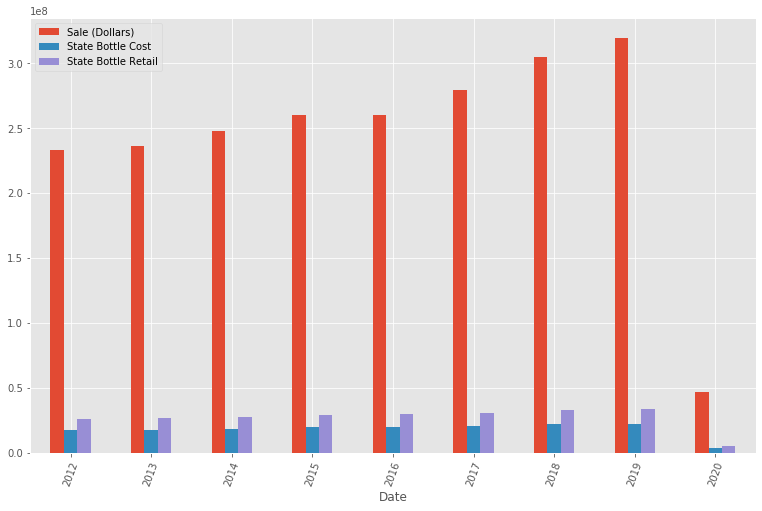

In [95]:
columns=['Date',"Sale (Dollars)","State Bottle Cost",'State Bottle Retail']
sales=yearly[columns]

sales.set_index('Date',inplace=True)
sales.plot.bar(rot=70)
plt.show(block=True);

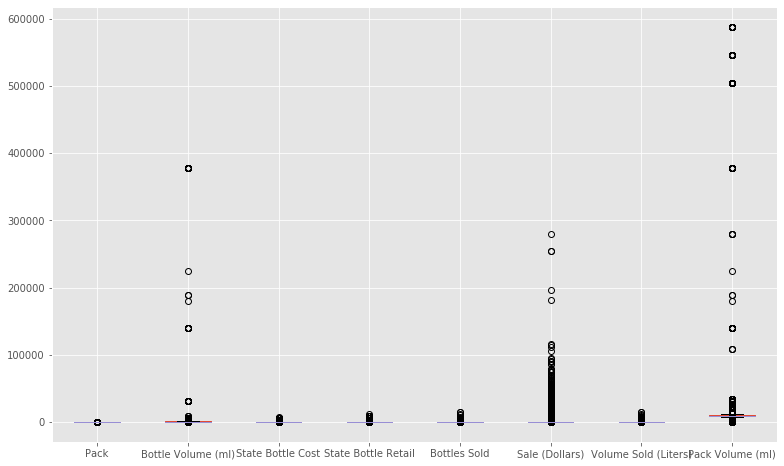

In [37]:
pd.plotting.boxplot(condensed.drop(columns=['Store Number','County Number','Category','Vendor Number','Item Number',
                               'Longtidute','Latitude','Month','Date','qtr_date'],axis=1));

**- From boxplot above, we can see all values of each attribute are pretty centralized. However, there are some outliers exist**

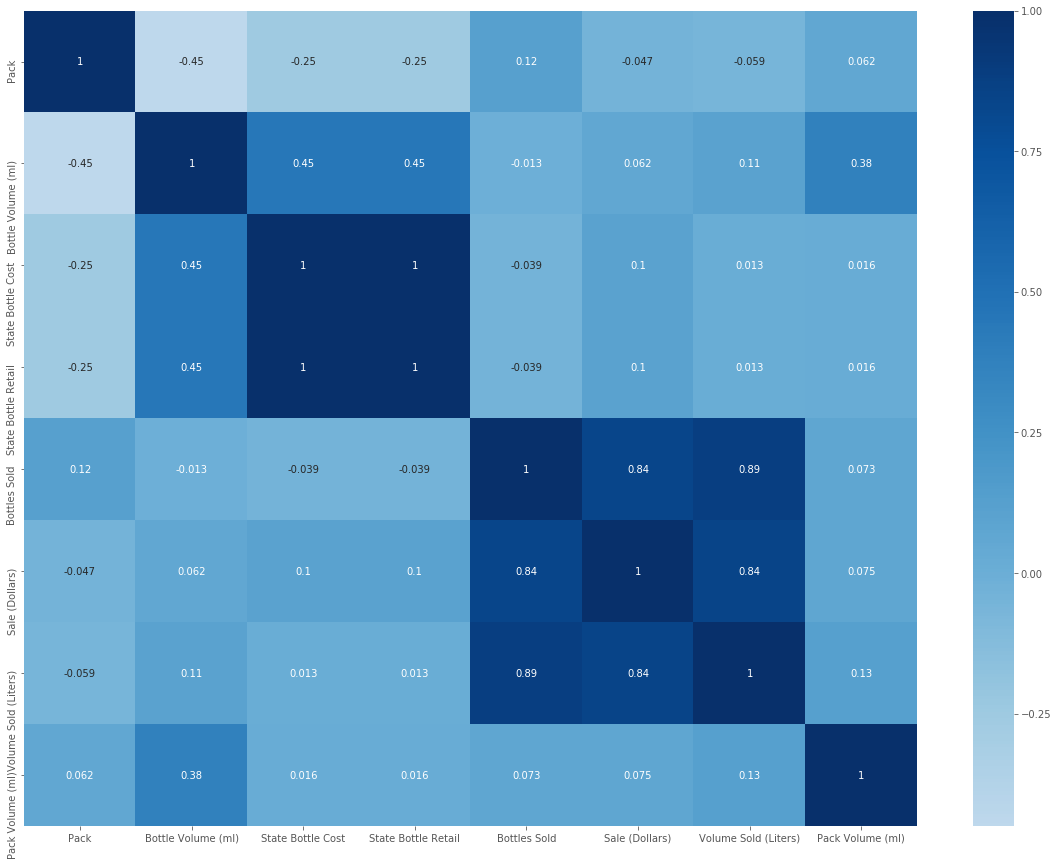

In [40]:
plt.figure(figsize=(20,15))
headmap=condensed.drop(columns=['Store Number','County Number','Category','Vendor Number','Item Number',
                               'Longtidute','Latitude','Month','Date','qtr_date'],axis=1)
sns.heatmap(headmap.corr(),cmap='Blues', annot=True,center=0);

**- From heatmap above, didn't see strong correlation between Sales related(Sale(Dollars), Bottle Sold, Volume Sold) with other attributes**

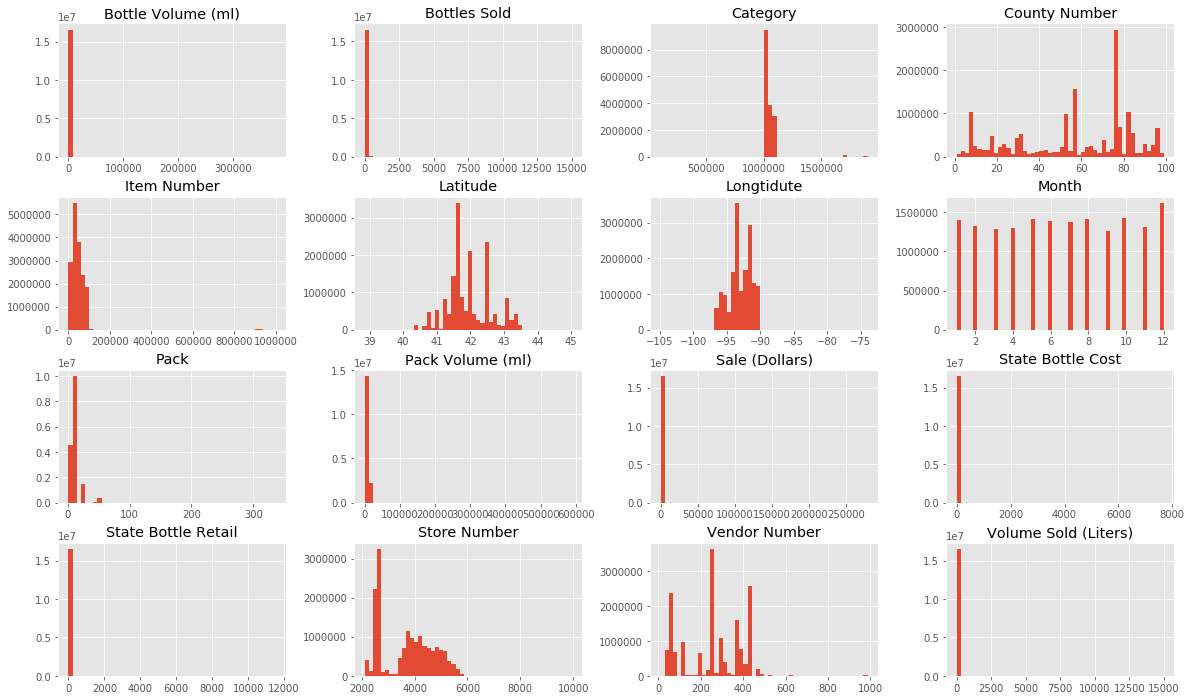

In [42]:
condensed.hist(bins=50, figsize=(20,12))
#save_fig("attribute_histogram_plots")
plt.show()

**From histogram we can see** 
   - there is 1 liquor category has the highest frequency
   - county, store, latitude, longidute have related each other, and there is 1 store number, related county we believe, with the significant highest frequency
   - Vendor has 3 with the relative high frequency